[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/jester_skorch.ipynb)

# Deep Colaborative Filtering using Skorch
This notebook follows the steps required to build and train a neural network for the purpose of collaborative filtering, using the [MovieLens](https://grouplens.org/datasets/movielens/latest/) data set.   

The neural network will be built using the [PyTorch](https://pytorch.org/) framework, with the [Skorch library](https://github.com/dnouri/skorch) being used to make training and testing the model simple.   

## Load data

In [ ]:
# ! [ ! -z "$COLAB_GPU" ] && pip install torch skorch

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'data/jester/long.csv'

In [14]:
df = pd.read_csv(data_path)

In [15]:
df.head()

,user_id,joke_id,rating
0,0,0,0.21875
1,1,0,-9.68750
2,2,0,-9.84375
3,3,0,6.90625
4,4,0,-0.03125


In [16]:
n_users = df.user_id.nunique()
n_items = df.joke_id.nunique()
max_score = max(df.rating)
min_score = min(df.rating)

In [17]:
print("Number of users:", n_users) 
print("Number of jokes:", n_items)
print("Ratings range between", min_score, "and", max_score)

Number of users: 50692
Number of jokes: 140
Ratings range between -10.0 and 10.0


In [18]:
print("Max user ID:", max(df.user_id.unique()))
print("Max joke ID:", max(df.joke_id.unique()))

Max user ID: 50691
Max joke ID: 139


There are a total of 50 692 users, who now each have a unique ID between 0 and 50 691, and similarly the movies now all have IDs between 0 and 139.

### Create test set
The next step is to split the data into train and test sets. A ratio of 80:20 will be used in this example.   

First, the data is separated into features (user Ids, movie Ids) and targets (ratings).

In [19]:
X = df.iloc[:,:2].values
y = df.iloc[:,2].values
y = y.astype('float32')

Then, the features and targets are separated into train and test sets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X[:,0])

In [21]:
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [22]:
X_train.shape, y_train.shape

((1383077, 2), (1383077, 1))

## Neural network
The next step is to create the neural network, using the PyTorch framework.   

This neural network will be pretty simple, with the input being simply a user-movie pair, and the output being a predicted rating.
Between the input and the output, we have two layers:   
  - embedding layer (with dropout)
  - hidden layer (with dropout and relu activation function)   
  
![Architecture](https://github.com/James-Leslie/Netflix-Recommender-System/blob/master/diagrams/EmbeddingNet.png?raw=true)   

The architecture shown above is very similar to that of a standard feed-forward neural network, with one significant difference.   

Each User and Movie ID will have a set of embeddings which can be 'learned' through training.   
Only when observations with that particular User or Movie ID are fed through the network, will the network activate (and update) the mapped embeddings.   
In other words, User1 and User2 will have different values for the nodes in the first layer. When passing ratings made my User1 into the network, then only User1's embedding layer will be trained.   
Similarly, when ratings for Movie1 are passed into the network, then only the movie embeddings associated to that movie will be updated through training.   

The hidden layer of the network is fully connected to the embedding layer, and thus will always be updated in any training batch.   

Finally, a scaled sigmoid activation function is used to squeeze the outputs between 0.5 and 5.0.

In [23]:
import torch
from torch import nn
import torch.nn.functional as F

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

In [26]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score, self.max_score = min_score, max_score

        # get user and item embeddings
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, 10)  # 10 hidden neurons
        self.lin2 = nn.Linear(10, 1)
        self.drop1 = nn.Dropout(0.1)  # dropout rate of 5%
        self.drop2 = nn.Dropout(0.25)  # dropout rate of 15%

    def forward(self, X, **kwargs):
        users, items = X[:,0], X[:,1]
        # concatenate embeddings to form first layer, add dropout
        x = self.drop1(torch.cat([self.u(users),self.i(items)], dim=1))
        # second layer with 10 hidden neurons and dropout
        x = self.drop2(F.relu(self.lin1(x)))
        # output layer with one neuron
        x = self.lin2(x)
        # add sigmoid activation function, but squeeze between min and max score
        return torch.sigmoid(x) * (self.max_score - self.min_score) + self.min_score

### Training using Skorch
The skorch library makes it easy to train the model, in a similar manner to Sk Learn models.

In [27]:
from skorch import NeuralNetRegressor

In [28]:
net = NeuralNetRegressor(
    module=EmbeddingNet,
    module__n_factors=10,
    module__n_users=n_users,
    module__n_items=n_items,
    module__min_score=min_score,
    module__max_score=max_score,
    max_epochs=7,
    lr=0.1,
    device=device,
)

In [29]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1       22.0421       19.0928  44.9042
      2       18.5893       18.2324  44.6705
      3       17.8501       18.0306  53.3354
      4       17.4386       17.9027  49.2124
      5       17.1755       18.0619  45.9461
      6       16.9395       17.7680  46.2224
      7       16.7471       17.8576  47.2008


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=EmbeddingNet(
    (u): Embedding(50692, 25)
    (i): Embedding(140, 25)
    (lin1): Linear(in_features=50, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
    (drop1): Dropout(p=0.1)
    (drop2): Dropout(p=0.25)
  ),
)

### Test on unseen data
As seen below, the RMSE score on the test set for this model is 4.23, which is better than any of the scores achieved in [this example](https://rpubs.com/jt_rpubs/285729).

In [30]:
preds = net.predict(X_test)

In [31]:
import seaborn as sns

C:\Users\jlesl\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


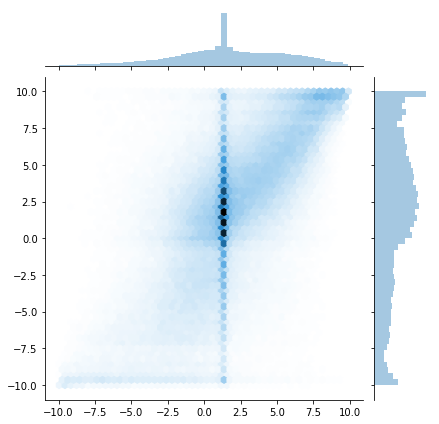

In [32]:
sns.jointplot(preds, y_test, kind='hex', stat_func=None);

In [33]:
np.sqrt(np.mean((preds - y_test) ** 2))

4.232447